In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from tueplots import bundles
import matplotlib.pyplot as plt
from tueplots.constants.color import rgb

plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({"figure.dpi": 300})

# Load Dataset

In [98]:
def load_dataset(data_path):
    source_columns = ["gx(rad/s)", "gy(rad/s)", "gz(rad/s)", "ax(m/s^2)", "ay(m/s^2)", "az(m/s^2)"]
    target_columns = ["px", "py", "pz"]
    
    source_sequences = []
    target_sequences = []
    
    for filename in os.listdir(data_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(data_path, filename)
        
            # Read the file using pandas
            df = pd.read_csv(file_path, sep=" ")
            
            # Extract required columns
            source_data = df[source_columns]
            target_data = df[target_columns]
        
            # Create source sequences of size (100, 6)
            for i in range(0, len(source_data) - 50, 50):
                source_seq = source_data.iloc[i:i+100, :].values
                source_sequences.append(source_seq)
        
            # Create target sequences of size (100, 3)
            for i in range(0, len(target_data) - 50, 50):
                target_seq = target_data.iloc[i:i+100, :].values
                target_sequences.append(target_seq)
        
            # Replace the last source sequence with the last 100 entries of the file
            last_source_seq = source_data.iloc[-100:, :].values
            source_sequences[-1] = last_source_seq
    
            # Replace the last target sequence with the last 100 entries of the file
            last_target_seq = target_data.iloc[-100:, :].values
            target_sequences[-1] = last_target_seq
    
    # Subtract the first row from all rows in each target sequence
    # target_sequences = [seq - seq[0] for seq in target_sequences]
    
    # Convert source sequences to torch tensor
    source_tensors = torch.stack([torch.from_numpy(seq) for seq in source_sequences])
    
    # Convert target sequences to torch tensor
    target_tensors = torch.stack([torch.from_numpy(seq) for seq in target_sequences])
    
    # Create TensorDatasets
    source_dataset = TensorDataset(source_tensors)
    target_dataset = TensorDataset(target_tensors)

    return source_dataset, target_dataset

In [99]:
train_data_path = './../dat/merged/train'
train_dataset = load_dataset(train_data_path)

val_data_path = './../dat/merged/val'
val_dataset = load_dataset(val_data_path)

test_data_path = './../dat/merged/test'
test_dataset = load_dataset(test_data_path)

# Print the shapes of train, validation, and test datasets
print("Train Dataset Source Shape:", train_dataset[0].tensors[0].shape)
print("Train Dataset Target Shape:", train_dataset[1].tensors[0].shape)
print("Validation Dataset Shape:", val_dataset[0].tensors[0].shape)
print("Validation Dataset Target Shape:", val_dataset[1].tensors[0].shape)
print("Test Dataset Shape:", test_dataset[0].tensors[0].shape)
print("Test Dataset Target Shape:", test_dataset[1].tensors[0].shape)

Train Dataset Source Shape: torch.Size([1354, 100, 6])
Train Dataset Target Shape: torch.Size([1354, 100, 3])
Validation Dataset Shape: torch.Size([376, 100, 6])
Validation Dataset Target Shape: torch.Size([376, 100, 3])
Test Dataset Shape: torch.Size([358, 100, 6])
Test Dataset Target Shape: torch.Size([358, 100, 3])


# Model

In [100]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=6):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=0.2)
        self.fc1 = nn.Linear(hidden_size, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 128)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(128, 64)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(64, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.relu4(out)
        out = self.fc5(out)
        return out

# Training

In [101]:
# Convert your datasets to PyTorch DataLoader
# Convert data to torch.float32 during loading or preprocessing
batch_size = 32
train_loader = DataLoader(TensorDataset(train_dataset[0].tensors[0].float(), train_dataset[1].tensors[0].float()), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_dataset[0].tensors[0].float(), val_dataset[1].tensors[0].float()), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(test_dataset[0].tensors[0].float(), test_dataset[1].tensors[0].float()), batch_size=batch_size)

In [102]:
input_size = 6
hidden_size = 256
output_size = 3
num_layers = 6  # Number of layers in the RNN
learning_rate = 1e-5
epochs = 200

# Instantiate the model, loss function, and optimizer
model = RNN(input_size, hidden_size, output_size, num_layers=num_layers)
criterion = nn.SmoothL1Loss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Losses
train_losses = []
val_losses = []

# Early stopping parameters
patience = 10  # Number of epochs to wait for improvement
best_val_loss = np.inf
current_patience = 0

# Training loop
for epoch in range(epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    train_losses.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for val_inputs, val_targets in val_loader:
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_targets).item()

    val_losses.append(val_loss / len(val_loader))

    print(f'Epoch {epoch+1} / {epochs}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss/len(val_loader):.4f}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        current_patience = 0

        # Save the model parameters when the best validation loss is achieved
        best_model_state = model.state_dict()
    else:
        current_patience += 1
        if current_patience >= patience:
            print(f'Early stopping at epoch {epoch+1} due to no improvement in validation loss.')
            break

# Load the best model parameters before using the model for testing or further inference
model.load_state_dict(best_model_state)

Epoch 1 / 10, Training Loss: 0.3947, Validation Loss: 0.5297
Epoch 2 / 10, Training Loss: 0.2428, Validation Loss: 0.3201
Epoch 3 / 10, Training Loss: 0.2189, Validation Loss: 0.2523
Epoch 4 / 10, Training Loss: 0.1715, Validation Loss: 0.2503
Epoch 5 / 10, Training Loss: 0.2041, Validation Loss: 0.2502
Epoch 6 / 10, Training Loss: 0.2426, Validation Loss: 0.2499
Epoch 7 / 10, Training Loss: 0.1529, Validation Loss: 0.2502
Epoch 8 / 10, Training Loss: 0.2279, Validation Loss: 0.2503
Epoch 9 / 10, Training Loss: 0.3174, Validation Loss: 0.2494
Epoch 10 / 10, Training Loss: 0.2702, Validation Loss: 0.2494


<All keys matched successfully>

# Errors

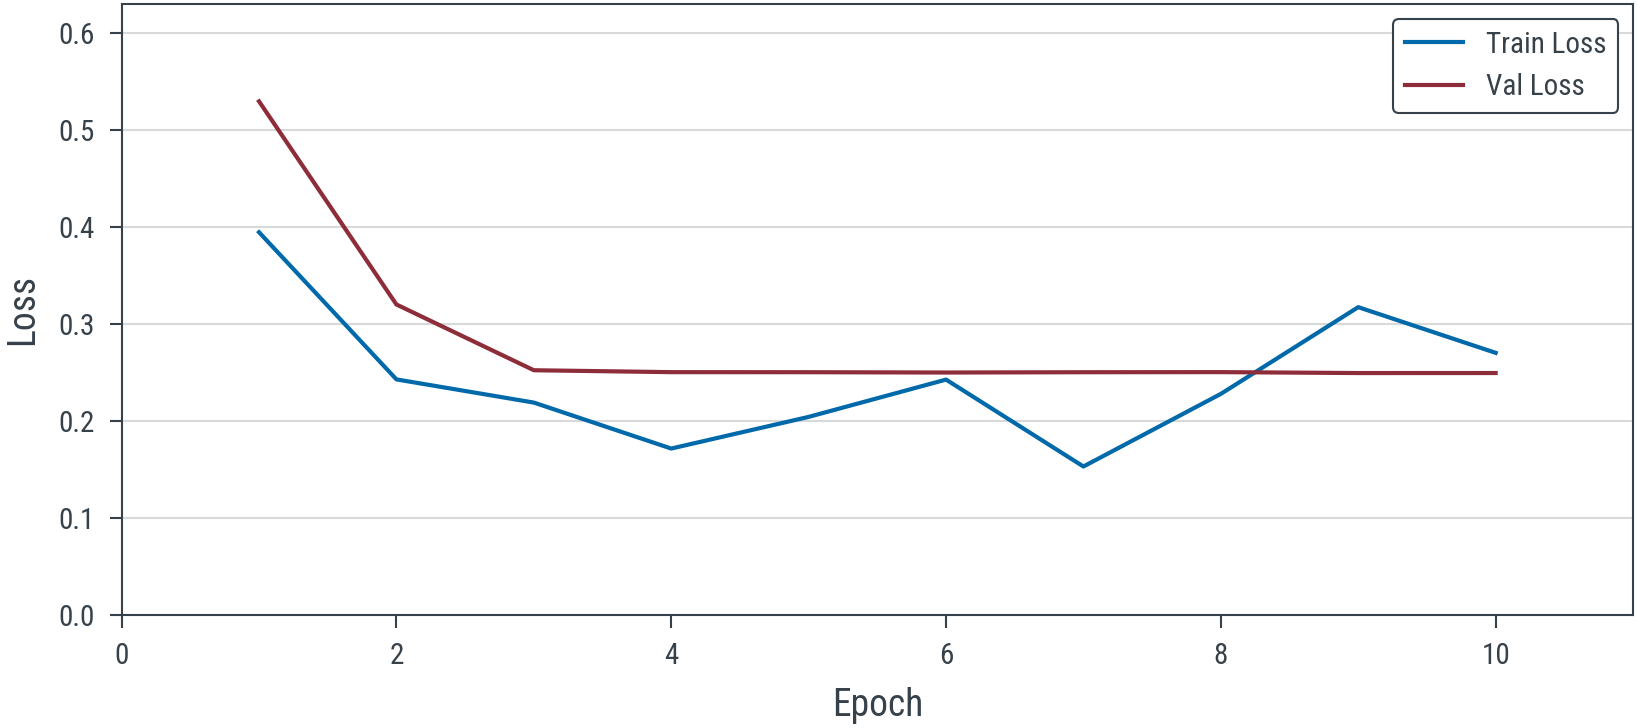

In [106]:
fig, ax = plt.subplots()

ax.plot(range(1, len(train_losses) + 1), train_losses, color=rgb.tue_blue, label="Train Loss")
ax.plot(range(1, len(val_losses) + 1), val_losses, color=rgb.tue_red, label="Val Loss")

ax.set_xlim([0, len(train_losses) + 1])
ax.set_ylim([0, max(max(train_losses), max(val_losses) + 0.1)])

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.grid(axis="y")

ax.legend(loc="upper right", framealpha=1, facecolor="white", frameon=True)

plt.show()

# Testing

In [107]:
# Testing
model.eval()
with torch.no_grad():
    test_loss = 0.0
    for test_inputs, test_targets in test_loader:
        test_outputs = model(test_inputs)
        test_loss += criterion(test_outputs, test_targets).item()

print(f'Test Loss: {test_loss / len(test_loader):.4f}')

Test Loss: 0.3112


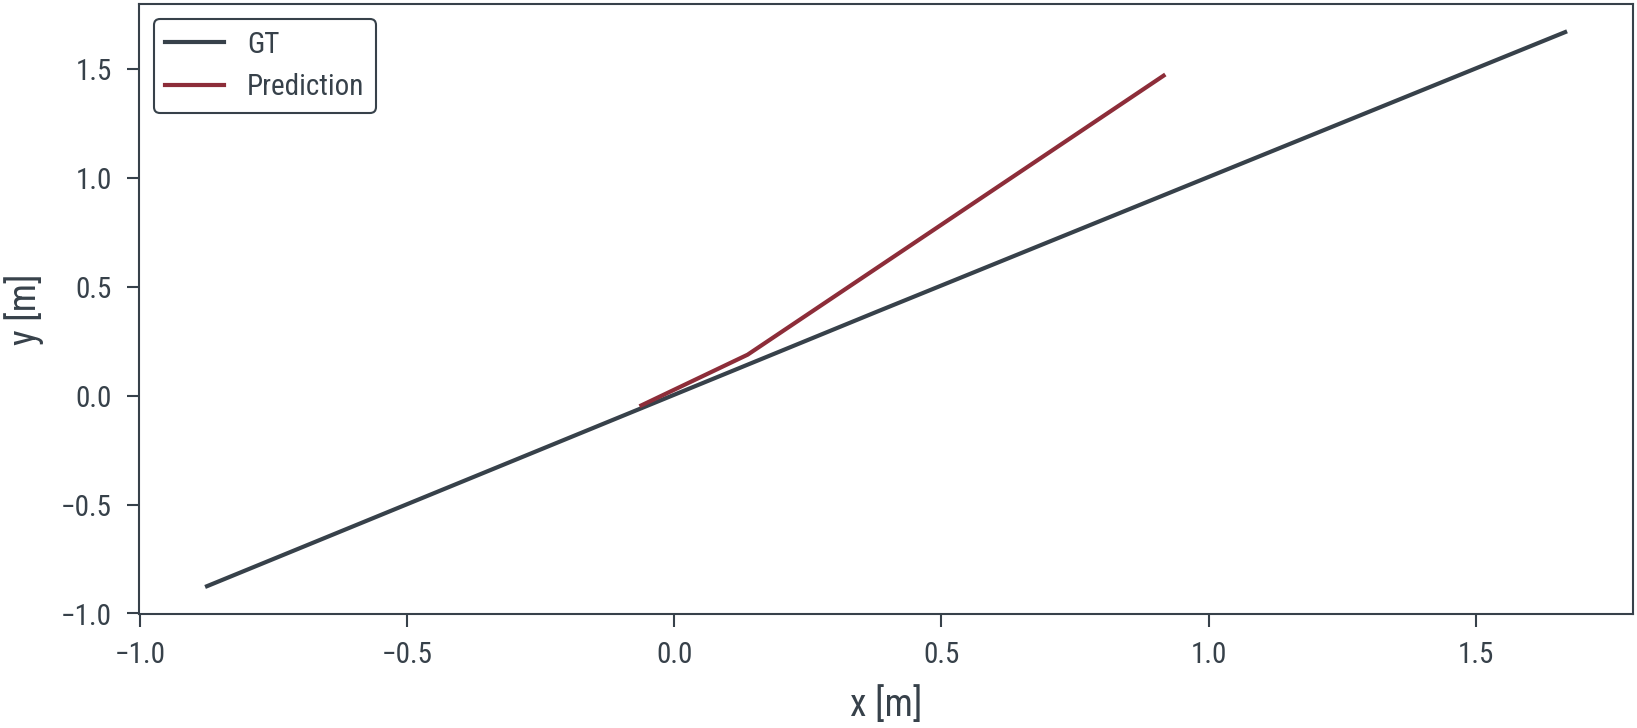

In [105]:
sequence_num = 150

gt = test_dataset[1].tensors[0][sequence_num].float()

model.eval()
with torch.no_grad():
    prediction = model(test_dataset[0].tensors[0][sequence_num].float())

fig, ax = plt.subplots()

ax.plot(gt[0], gt[1], color=rgb.tue_dark, label="GT")
ax.plot(prediction[0], prediction[1], color=rgb.tue_red, label="Prediction")

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

ax.legend(loc="upper left", framealpha=1, facecolor="white", frameon=True)

plt.show()